## PyProffit Profiles 

This notebook is for creating spectral profiles and fitting them using [`pyproffit`](https://github.com/domeckert/pyproffit)

You can only run this notebook if its in a python environment with pyproffit installed

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import Angle
import astropy.units as u
import pandas as pd
from matplotlib.patches import Wedge

from astropy.wcs import WCS
from matplotlib.patches import Wedge

import importlib

In [4]:
import pyproffit

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [5]:
importlib.reload(pyproffit)

<module 'pyproffit' from '/Users/osaseomoruyi/opt/anaconda3/envs/pyprof_env/lib/python3.9/site-packages/pyproffit/__init__.py'>

## 1. Set Abell 2597 Specific Parameters

In [6]:
obsids = [ # '922', # 922 is in FAINT mode and has a terrible flare, let's just ditch it
          '6934', # 56.0 ksec, Clarke ACIS-S3 VFAINT
          '7329', # 60.11 ksec, Clarke ACIS-S3 VFAINT
          '19596', # 69.39 ksec, Tremblay ACIS S3 VFAINT
          '19597', # 44.52
          '19598', # 14.34
          '20626', # 24.73
          '20627', # 20.85
          '20628', # 10.92
          '20629', # 56.36
          '20805', # 53.4
          '20806', # 37.62
          '20811', # 79.85
          '20817'] # 62.29

name = 'Abell 2597'
rah, decd = '23h25m19.7s', '-12d07m27s'
coord = SkyCoord(rah, decd, frame='icrs')
ra = coord.ra.degree
dec = coord.dec.degree
radius = Angle(20, u.arcsec)

z = 0.0821
zh = 0.0821
nH = 2.252e+20 # % (HI4PI)   DL,LAB: 2.500e+20 2.515e+20
kT_guess = 4.0 # keV
abundance_guess = 0.4
r500 = 904.8 # kpc This is R_500_Y from Vikhlinin et al.
r500_err = 2.4 #
m500 = 2.279e14 # Msol This is M_500_Y from Vikhlinin et al.
m500_err = 1.797e12

acis_pixel_scale = 0.4920 * u.arcsec


cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
angular_diameter_distance = cosmo.angular_diameter_distance(z=z) # in Mpc
kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z=z).to(u.kpc / u.arcsec)
print(f'At a redshift of {z}, the angular diameter distance is {np.round(angular_diameter_distance,4)}')
print(f'At a redshift of {z}, we have {np.round(kpc_per_arcsec,4)}')

At a redshift of 0.0821, the angular diameter distance is 318.8353 Mpc
At a redshift of 0.0821, we have 1.5458 kpc / arcsec


In [7]:
#change to data irectory
savepath = '/Users/osaseomoruyi/research/a2597/chandra/careful_analysis/joint_analysis/'
regpath = '/Users/osaseomoruyi/research/a2597/chandra/careful_analysis/regions/'

starting_dir = '/Users/osaseomoruyi/research/a2597/chandra/'
obsID_dir = os.path.join(starting_dir, 'obsIDs/')
joint_analysis_dir = os.path.join(starting_dir, 'joint_analysis/')

# we'll save the spectral fits to a separate folder
specfit_savepath = os.path.join(joint_analysis_dir, 'spectral_fits/')

os.chdir(savepath)


## Loading and Prepping Data in Pyproffit

Loading the merged, reprojected counts image (i.e. broad_thresh.img)

In [8]:
data = pyproffit.Data(imglink='broad_thresh_bgndsubtract.img',explink=None,bkglink=None)


Set MJD-END to 58048.807847 from DATE-END'. [astropy.wcs.wcs]


### Exclude Point Sources

In [9]:
data.region(regpath + 'omo_wavedetect_src_ds9.reg' )

Excluded 280 sources


## Quality Check: Does the Extracted SB Profile look like A2597?

Answer: yes!

### Profile extraction

In [8]:
annuli_width = 0.5 #arcsec
maxrad = 5.0 #arcmin
prof=pyproffit.Profile(data,center_choice='peak',maxrad=3.,binsize=0.5) 


Determining X-ray peak
Coordinates of surface-brightness peak: 4180.0 4418.0
Corresponding FK5 coordinates:  351.3322351635786 -12.123976175136232


In [9]:
prof.SBprofile() #circular annuli

<Figure size 640x480 with 0 Axes>

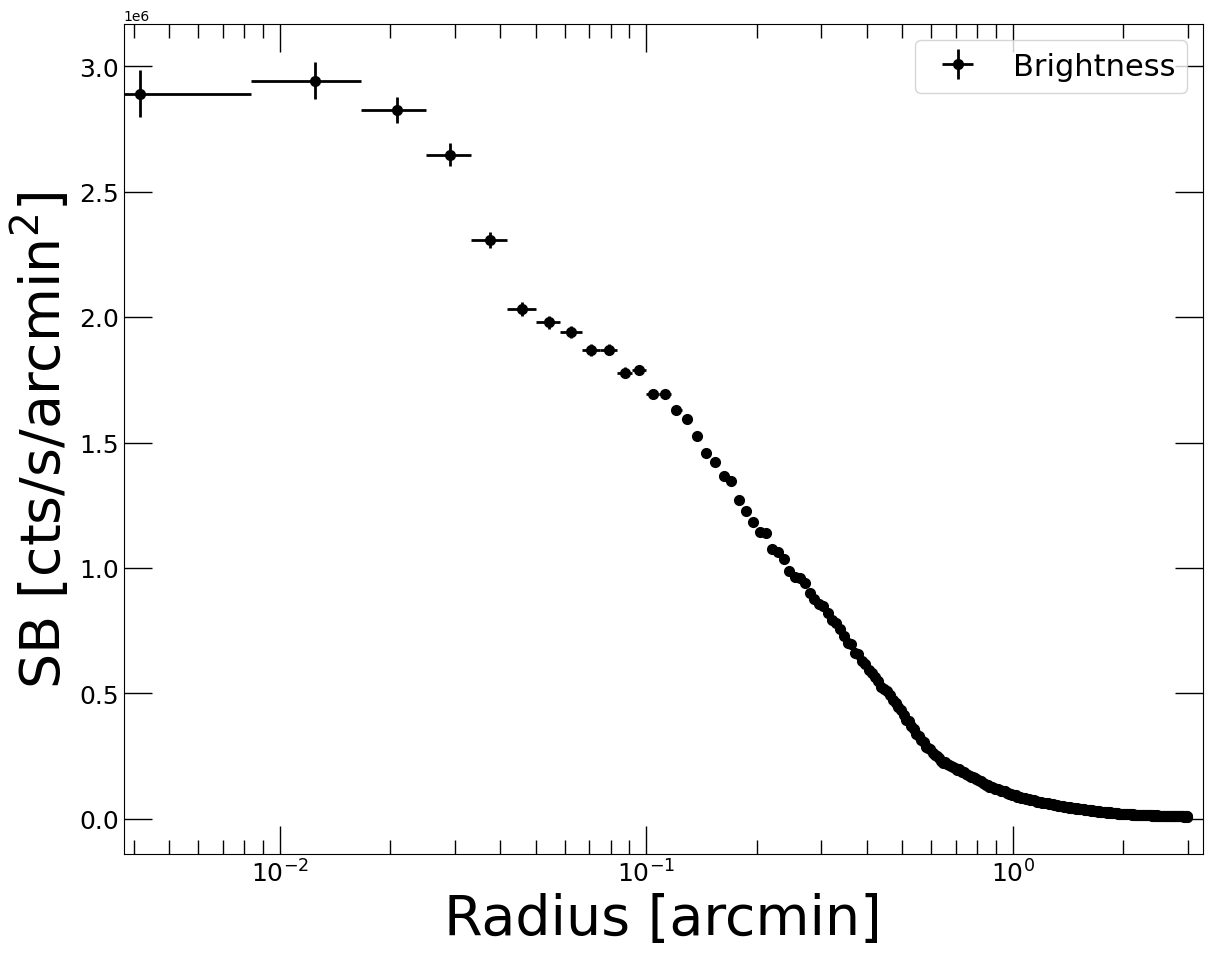

In [17]:
prof.Plot(yscale='linear')

## Onto the Real Analysis: Cocoon Shocks??

From the total surface brightness profile above, there are very clear SB edges. Let's see if they align with the locations of our speculated "cocoon" shocks. 

In [238]:
annuli_width = 0.25 #arcsec
maxrad = 2.0 #arcmin
#panda(351.3228274,-12.1147346,212.68887,245.57828,1,57.828",115.656",4)

prof_se = pyproffit.Profile(data=data, binsize=annuli_width, maxrad=maxrad,
                         center_choice='custom_fk5', center_ra=351.3321221, 
                         center_dec=-12.1242783)

#panda(351.3321221,-12.1242783,218.21695,256.09147,1,0.000",18.490",1)


Corresponding pixels coordinates:  4181.617699790011 4413.578666608705


In [239]:
prof_se.SBprofile(angle_low=218.21695, angle_high=256.09147)


In [240]:
prof_se.cra, prof_se.cdec

(351.3321221, -12.1242783)

In [241]:
prof_se.anglow, prof_se.anghigh

(218.21695, 256.09147)

Set MJD-END to 58048.807847 from DATE-END'. [astropy.wcs.wcs]
/var/folders/q9/nqsw_gnn1kq4pydg796lnc880000gn/T/ipykernel_7434/4125197307.py:8: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(prof_sw.data.img), origin='lower', cmap='magma')
/var/folders/q9/nqsw_gnn1kq4pydg796lnc880000gn/T/ipykernel_7434/4125197307.py:8: RuntimeWarning: invalid value encountered in log10
  ax.imshow(np.log10(prof_sw.data.img), origin='lower', cmap='magma')


(3482.1352, 4978.9400000000005)

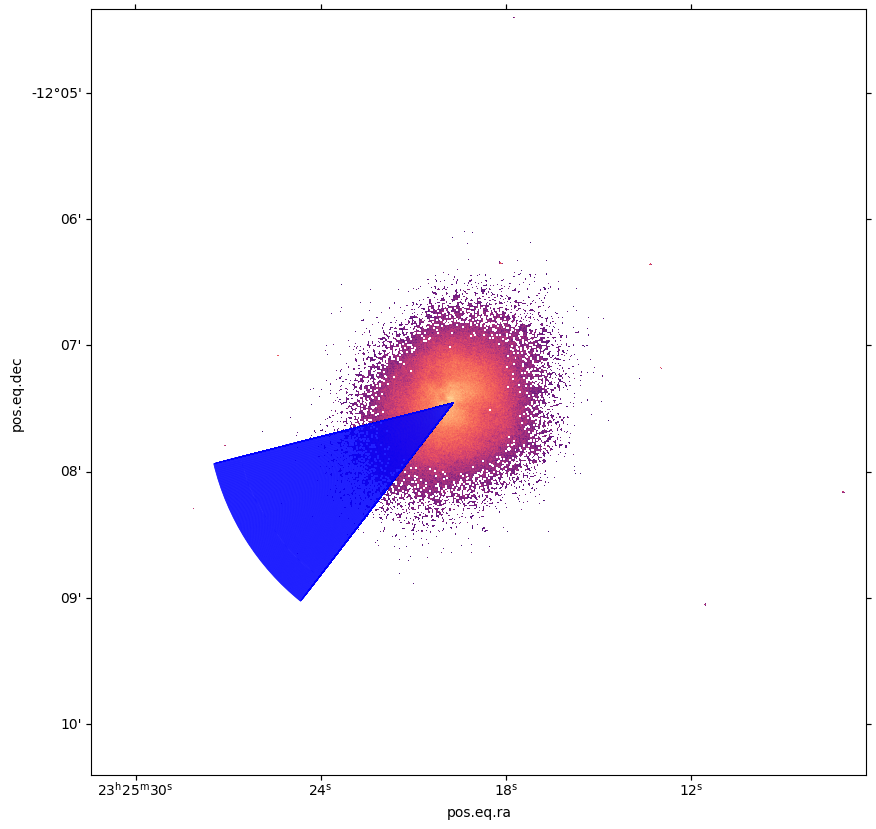

In [242]:
imhdr = prof_se.data.header
wcs = WCS(imhdr)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=wcs)

# custom zoom for ff.img.07-2.gz
ax.imshow(np.log10(prof_se.data.img), origin='lower', cmap='magma')

profs = [prof_se]
# profs = [prof_se] 
prof_colors = ['blue', 'orange', 'green', 'red']

for idp, wedge_prof in enumerate(profs):
    radii = wedge_prof.bins
    for rad in radii:
        rad = (rad * u.arcmin).to(u.deg).value
        sector = Wedge((wedge_prof.cra, wedge_prof.cdec), rad, 90+wedge_prof.anglow, 90+wedge_prof.anghigh,
                    edgecolor=prof_colors[idp], facecolor='none', transform=ax.get_transform('world'),
                    lw=0.5)
        ax.add_patch(sector)

xlim_width = ax.get_xlim()[1] - ax.get_xlim()[0]
ylim_width = ax.get_ylim()[1] - ax.get_ylim()[0]
xlim_start, xlim_end = ax.get_xlim()
ylim_start, ylim_end = ax.get_ylim()
xfactor = 0.33
yfactor = 0.4
ax.set_ylim(ylim_start + yfactor * ylim_width, ylim_end - 1.1*yfactor * ylim_width)
ax.set_xlim(xlim_start + 1.42*xfactor * xlim_width, xlim_end - xfactor * xlim_width)

### Edges

#### Fit Edge #1

In [246]:
modbkn = pyproffit.Model(pyproffit.BknPow)

print(modbkn.parnames)

('alpha1', 'alpha2', 'rf', 'norm', 'jump', 'bkg')


<Figure size 640x480 with 0 Axes>

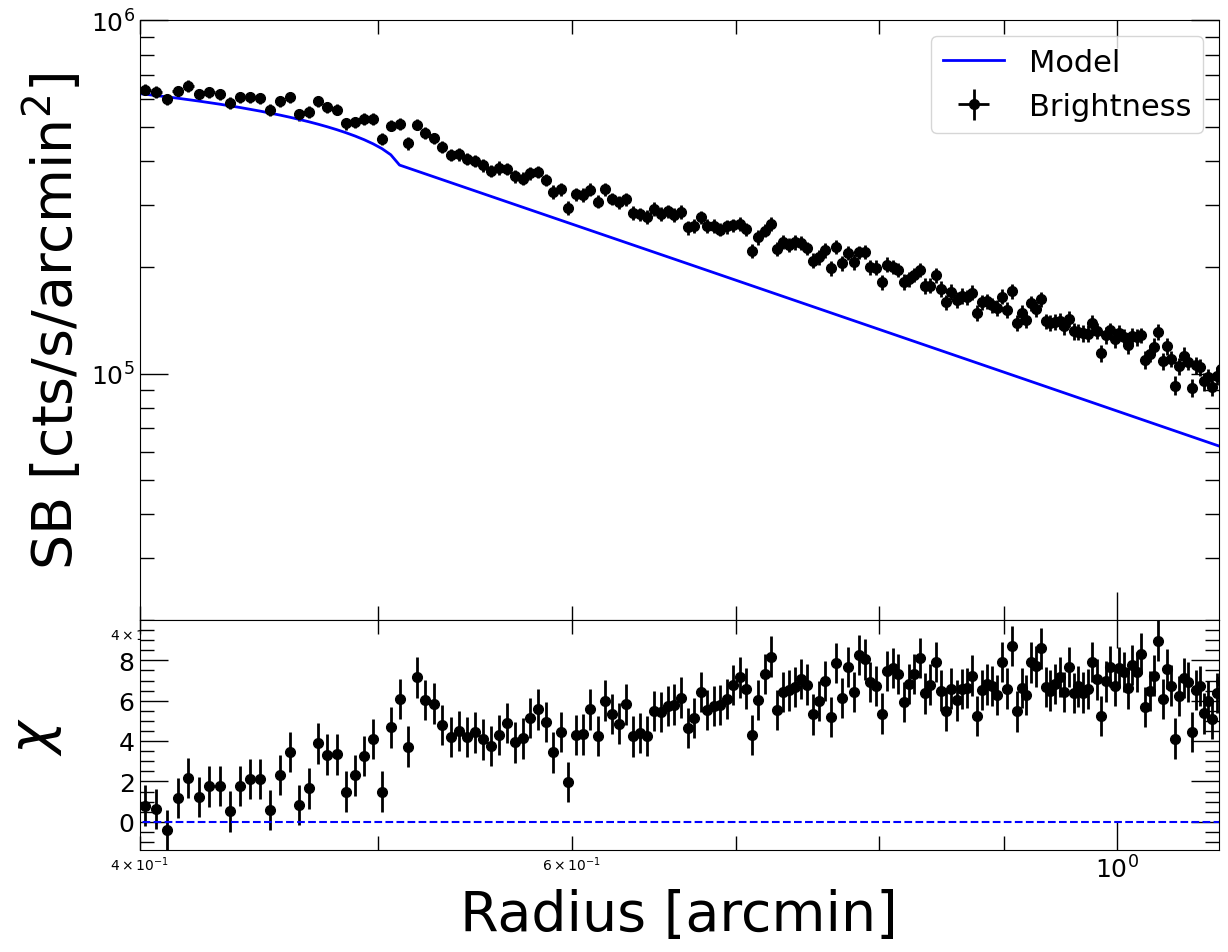

In [261]:
alpha1, alpha2, rf, norm, jump, bkg = [0.01, 1.7, 0.51, 6.1, 1.2, 0]
xmin, xmax = 0.4, 1.1
ymin, ymax = 0.02e6, 0.8e6

modbkn.SetParameters([alpha1, alpha2, rf, norm, jump, bkg])

prof_se.Plot(model=modbkn, axes=[xmin, xmax, 0.02e6, 1e6], xscale='log', yscale='log')


In [248]:
fitobj = pyproffit.Fitter(model=modbkn, profile=prof_se, alpha1=alpha1, alpha2=alpha2, rf=rf, jump=jump, norm=norm, bkg=bkg,
                fitlow=xmin, fithigh=xmax)

fitobj.Migrad()

/Users/osaseomoruyi/opt/anaconda3/envs/pyprof_env/lib/python3.9/site-packages/pyproffit/fitting.py:58: FutureWarning: make_func_code is deprecated: Use of ``func_code`` attribute to declare parameters is deprecated. Use ``_parameters`` instead, which is a dict of parameter names to limits.
  self.func_code = iminuit.util.make_func_code(iminuit.util.describe(self.model)[1:])
/Users/osaseomoruyi/opt/anaconda3/envs/pyprof_env/lib/python3.9/site-packages/pyproffit/models.py:168: RuntimeWarning: overflow encountered in power
  term2 = np.power(term1,-alpha)
/Users/osaseomoruyi/opt/anaconda3/envs/pyprof_env/lib/python3.9/site-packages/pyproffit/fitting.py:74: RuntimeWarning: overflow encountered in square
  chi2 = np.sum((self.y[reg][nonz] - ym[reg][nonz])**2/self.dy[reg][nonz]**2)
/Users/osaseomoruyi/opt/anaconda3/envs/pyprof_env/lib/python3.9/site-packages/pyproffit/models.py:213: RuntimeWarning: invalid value encountered in multiply
  out[outreg] = A2 * term


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 204.4                      │             Nfcn = 1851              │
│ EDM = 0.697 (Goal: 0.0002)       │            time = 3.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

<Figure size 640x480 with 0 Axes>

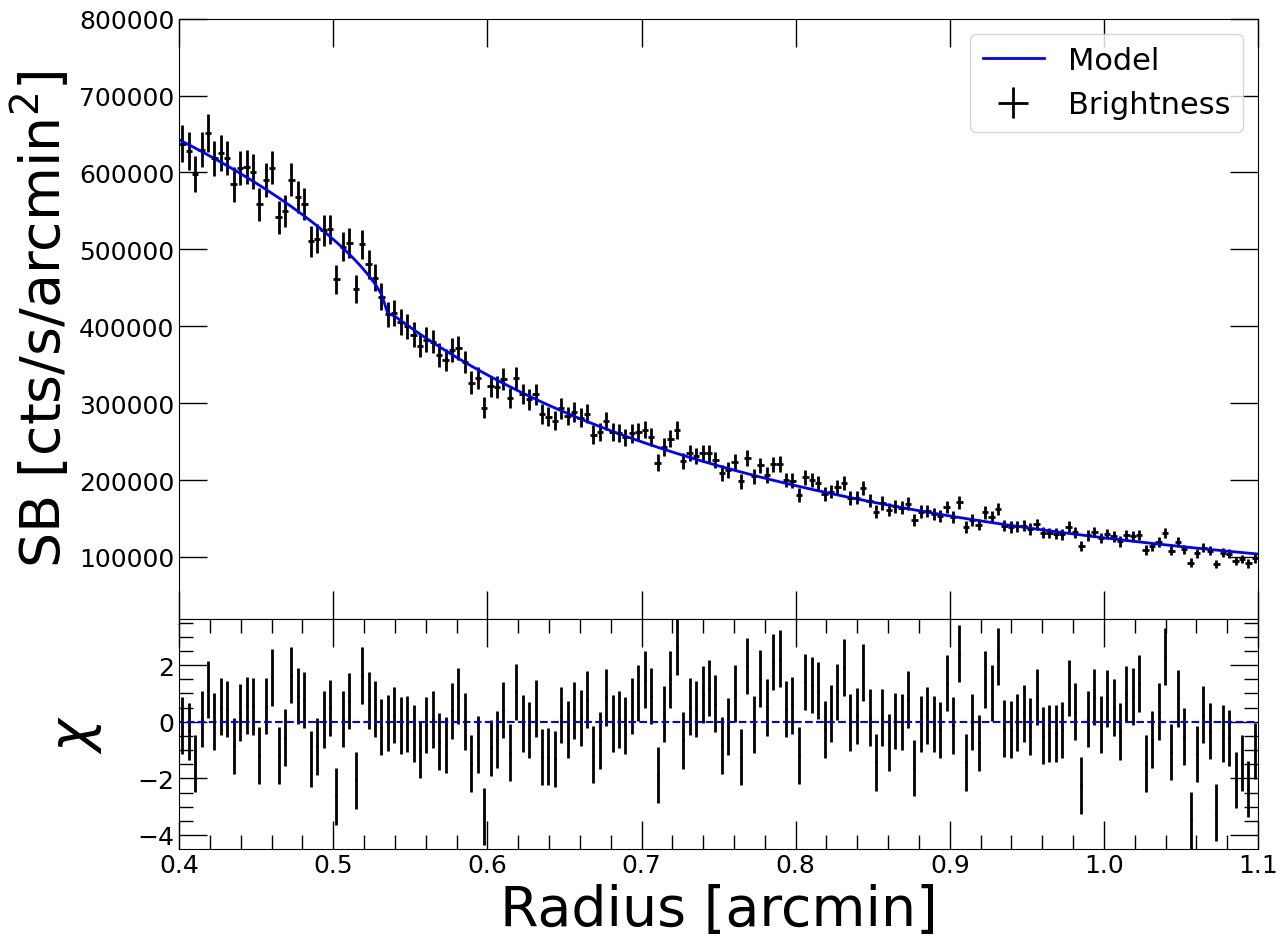

In [250]:
prof_se.Plot(model=modbkn, axes=[xmin, xmax, ymin, ymax], xscale='linear', yscale='linear', markersize=1)

In [251]:
save_name = 'se_wedge_edge1'

model_fit = modbkn.model(prof_se.bins, *modbkn.params)
chi = (prof_se.profile - model_fit) / prof_se.eprof

#save data, model and chi2 values
df = pd.DataFrame()
df['radius'] = prof_se.bins
df['sb'] = prof_se.profile
df['sb_err'] = prof_se.eprof
df['model'] = model_fit
df['chi'] = chi

date = '020425'

np.save(specfit_savepath + f'pyproffit_{date}_{save_name}', df.to_records())

In [252]:
fitobj.out

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 204.4                      │             Nfcn = 1851              │
│ EDM = 0.697 (Goal: 0.0002)       │            time = 3.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ alpha1 │   0.09    │   0.16    │            │            │         │         │       │
│ 1 │ alpha2 │   1.476   │   0.010   │            │            │         │         │       │
│ 2 │ rf     │535.4167e-3│ 0.0015e-3 │            │            │         │         │       │
│ 3 │ norm   │   6.031   │   0.017   │            │            │         │         │       │
│ 4 │ jump   │   1.168   │   0.027   │            │            │         │         │       │
│ 5 │ bkg    │    -0     │    40     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────────────────┐
│        │     alpha1     alpha2         rf       norm       jump        bkg │
├────────┼───────────────────────────────────────────────────────────────────┤
│ alpha1 │     0.0251    0.26e-3 -1.3287e-9   -2.52e-3    -3.6e-3      0.002 │
│ alpha2 │    0.26e-3    9.2e-05 -244.0e-12   -0.05e-3   -0.13e-3    5.23e-3 │
│     rf │ -1.3287e-9 -244.0e-12   2.18e-12  215.2e-12  525.5e-12 -2.5171e-9 │
│   norm │   -2.52e-3   -0.05e-3  215.2e-12   0.000298    0.45e-3   -0.53e-3 │
│   jump │    -3.6e-3   -0.13e-3  525.5e-12    0.45e-3   0.000722    -1.6e-3 │
│    bkg │      0.002    5.23e-3 -2.5171e-9   -0.53e-3    -1.6e-3   1.28e+03 │
└────────┴───────────────────────────────────────────────────────────────────┘

#### Fit Edge #2

In [290]:
modbkn = pyproffit.Model(pyproffit.BknPow)

print(modbkn.parnames)

('alpha1', 'alpha2', 'rf', 'norm', 'jump', 'bkg')


<Figure size 640x480 with 0 Axes>

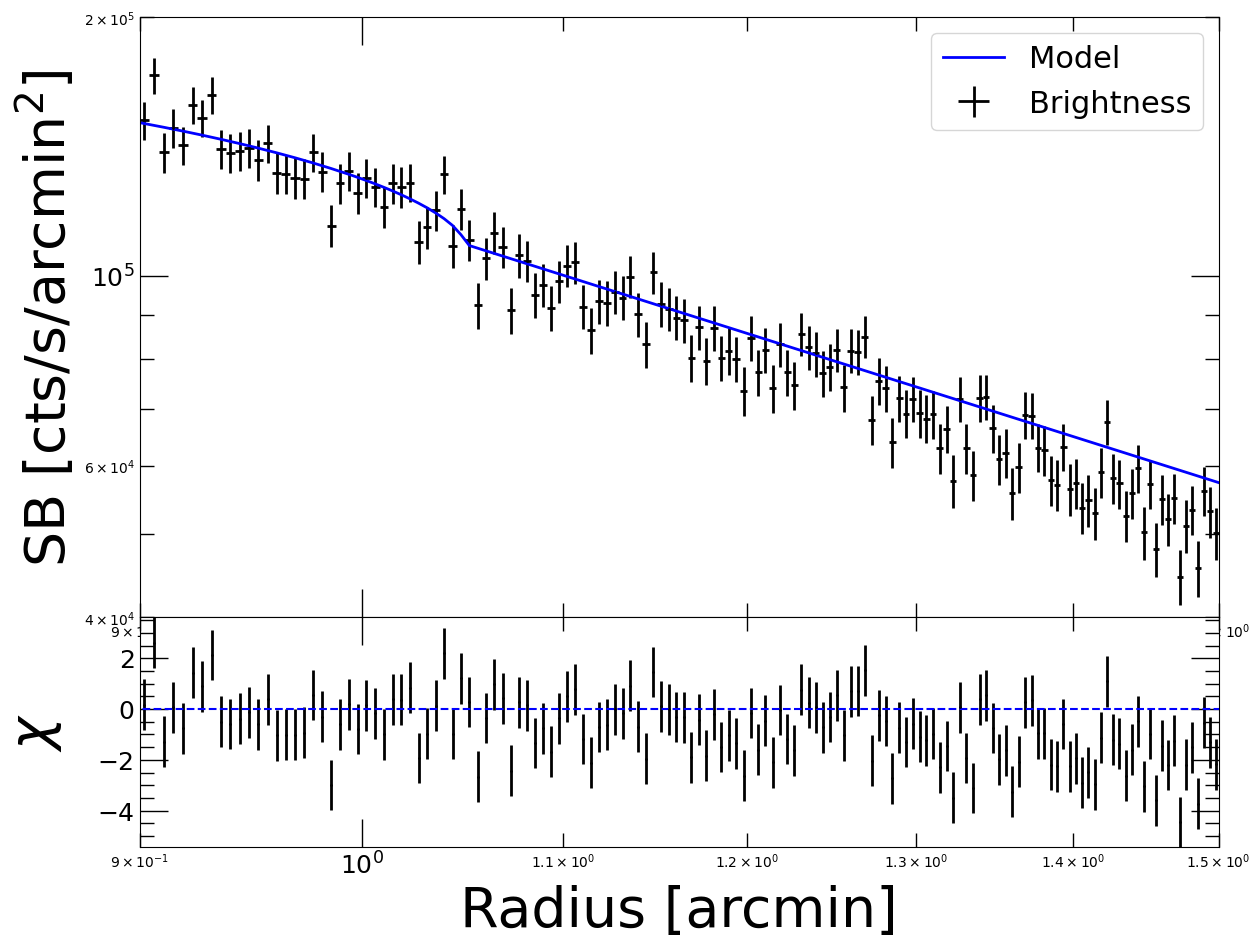

In [316]:
edge = 1.05
alpha1, alpha2, rf, norm, jump, bkg = [0.1, 1.4, edge, 5.15, 1.2, 0]
xmin, xmax = 0.9, 1.5
ymin, ymax = 0.4e5, 0.2e6
xscale, yscale = 'log', 'log'

modbkn.SetParameters([alpha1, alpha2, rf, norm, jump, bkg])

prof_se.Plot(model=modbkn, axes=[xmin, xmax, ymin, ymax], xscale=xscale, yscale=yscale, markersize=1)


In [317]:

fitobj = pyproffit.Fitter(model=modbkn, profile=prof_se, alpha1=alpha1, alpha2=alpha2, rf=rf, jump=jump, norm=norm, bkg=bkg,
                fitlow=xmin, fithigh=xmax)

fitobj.Migrad()

/Users/osaseomoruyi/opt/anaconda3/envs/pyprof_env/lib/python3.9/site-packages/pyproffit/fitting.py:58: FutureWarning: make_func_code is deprecated: Use of ``func_code`` attribute to declare parameters is deprecated. Use ``_parameters`` instead, which is a dict of parameter names to limits.
  self.func_code = iminuit.util.make_func_code(iminuit.util.describe(self.model)[1:])
/Users/osaseomoruyi/opt/anaconda3/envs/pyprof_env/lib/python3.9/site-packages/pyproffit/models.py:204: RuntimeWarning: overflow encountered in power
  A1 = np.power(10.,norm)
/Users/osaseomoruyi/opt/anaconda3/envs/pyprof_env/lib/python3.9/site-packages/pyproffit/models.py:168: RuntimeWarning: overflow encountered in power
  term2 = np.power(term1,-alpha)
/Users/osaseomoruyi/opt/anaconda3/envs/pyprof_env/lib/python3.9/site-packages/pyproffit/models.py:214: RuntimeWarning: overflow encountered in power
  c2 = np.power(10., bkg)
/Users/osaseomoruyi/opt/anaconda3/envs/pyprof_env/lib/python3.9/site-packages/pyproffit/fit

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 168.8                      │             Nfcn = 1222              │
│ EDM = 2.54 (Goal: 0.0002)        │            time = 2.9 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

In [345]:
(1.05 * u.arcmin * kpc_per_arcsec).to(u.kpc)

<Quantity 97.38270122 kpc>

<Figure size 640x480 with 0 Axes>

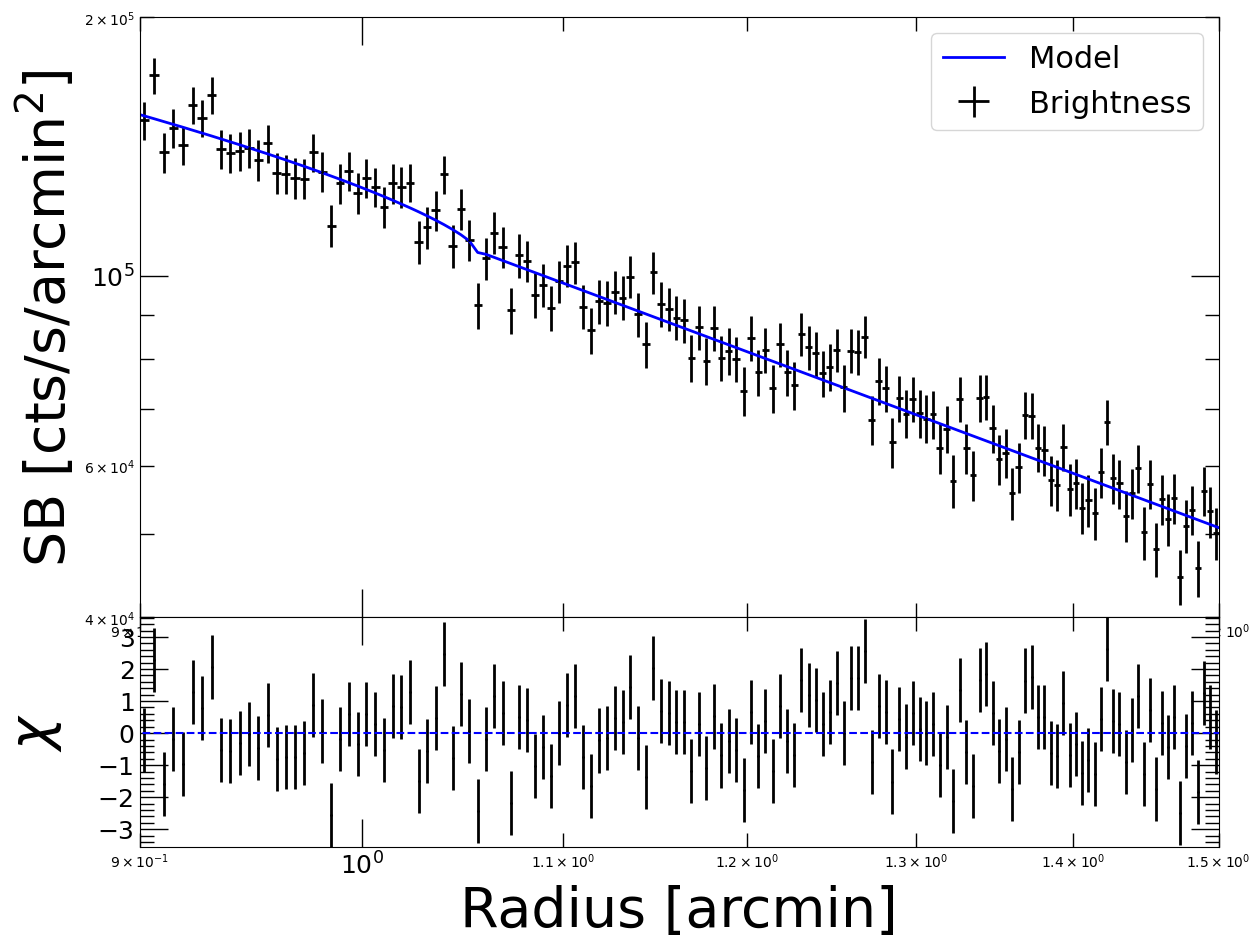

In [318]:

prof_se.Plot(model=modbkn, axes=[xmin, xmax, ymin, ymax], xscale=xscale, yscale=yscale, markersize=1)

In [320]:
save_name = 'se_wedge_edge2'

model_fit = modbkn.model(prof_se.bins, *modbkn.params)
chi = (prof_se.profile - model_fit) / prof_se.eprof

#save data, model and chi2 values
df = pd.DataFrame()
df['radius'] = prof_se.bins
df['sb'] = prof_se.profile
df['sb_err'] = prof_se.eprof
df['model'] = model_fit
df['chi'] = chi

date = '020425'

np.save(specfit_savepath + f'pyproffit_{date}_{save_name}', df.to_records())

In [321]:
fitobj.out

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 168.8                      │             Nfcn = 1222              │
│ EDM = 2.54 (Goal: 0.0002)        │            time = 2.9 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ alpha1 │    0.8    │    0.4    │            │            │         │         │       │
│ 1 │ alpha2 │   1.561   │   0.029   │            │            │         │         │       │
│ 2 │ rf     │ 1.0562500 │ 0.0000012 │            │            │         │         │       │
│ 3 │ norm   │   5.117   │   0.029   │            │            │         │         │       │
│ 4 │ jump   │   1.11    │   0.04    │            │            │         │         │       │
│ 5 │ bkg    │    -0     │   0.6e3   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────────────────┐
│        │     alpha1     alpha2         rf       norm       jump        bkg │
├────────┼───────────────────────────────────────────────────────────────────┤
│ alpha1 │       0.19     2.6e-3  2.8010e-9   -11.7e-3    -0.0165       0.03 │
│ alpha2 │     2.6e-3   0.000841  -73.2e-12    -0.2e-3    -0.7e-3    78.5e-3 │
│     rf │  2.8010e-9  -73.2e-12   1.35e-12 -178.8e-12 -182.9e-12  2.9364e-9 │
│   norm │   -11.7e-3    -0.2e-3 -178.8e-12   0.000821     1.2e-3    -6.5e-3 │
│   jump │    -0.0165    -0.7e-3 -182.9e-12     1.2e-3    0.00194    -0.0065 │
│    bkg │       0.03    78.5e-3  2.9364e-9    -6.5e-3    -0.0065   4.11e+05 │
└────────┴───────────────────────────────────────────────────────────────────┘

#### Fit Edge #3

In [401]:
modbkn = pyproffit.Model(pyproffit.BknPow)

print(modbkn.parnames)

('alpha1', 'alpha2', 'rf', 'norm', 'jump', 'bkg')


<Figure size 640x480 with 0 Axes>

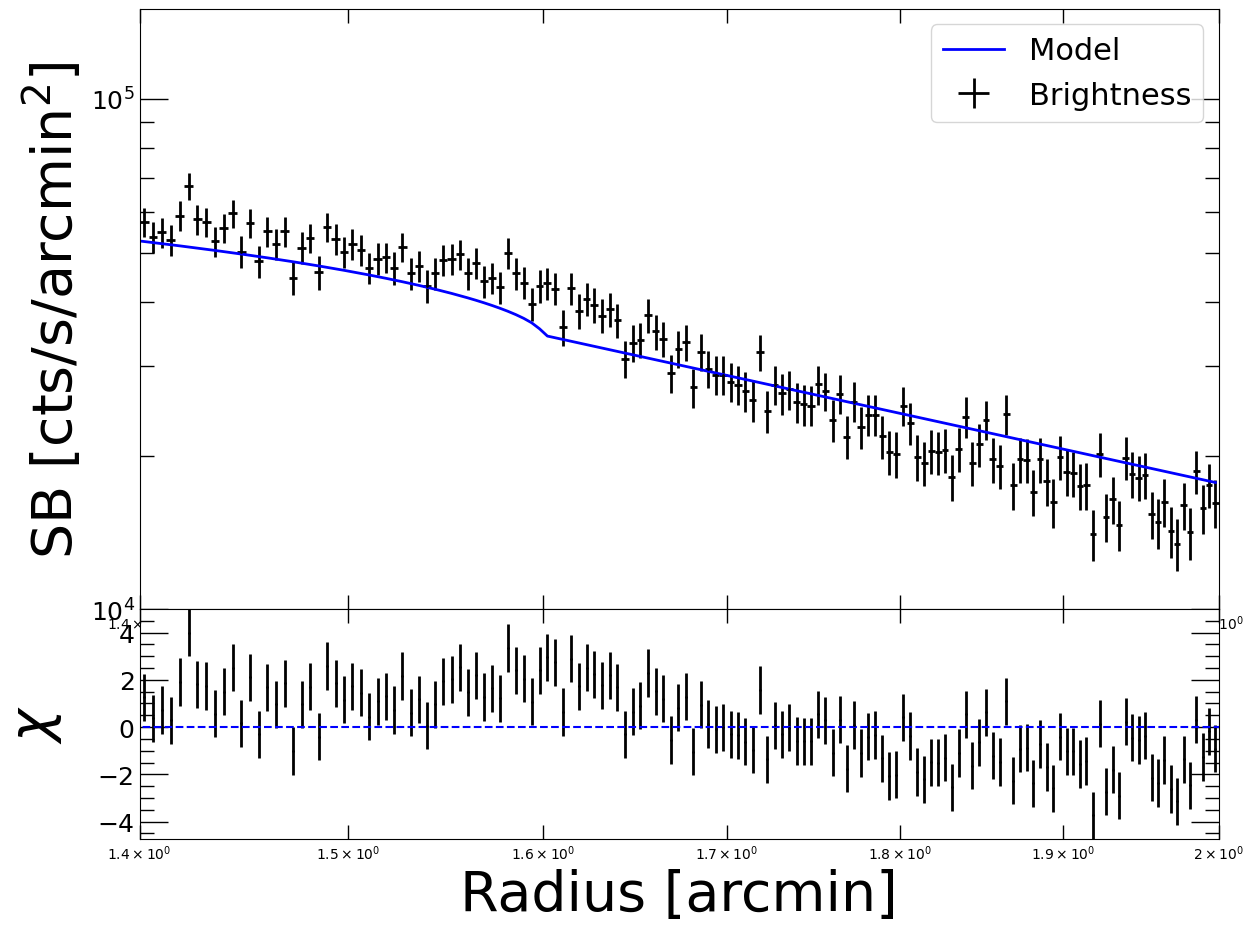

In [404]:
edge = 1.6
alpha1, alpha2, rf, norm, jump, bkg = [0.2, 2., edge, 4.6, 1.2, 0]
xmin, xmax = 1.4, 2.0
ymin, ymax = 0.1e5, 0.15e6
xscale, yscale = 'log', 'log'

modbkn.SetParameters([alpha1, alpha2, rf, norm, jump, bkg])

prof_se.Plot(model=modbkn, axes=[xmin, xmax, ymin, ymax], xscale=xscale, yscale=yscale, markersize=1)


In [405]:
# fitobj = pyproffit.Fitter(model=modbkn, profile=prof, alpha1=0.8, alpha2=2.0, rf=3.5, jump=1.8, norm=-1.8, bkg=-4.0,
#               fitlow=1.0, fithigh=7.0)
fitobj = pyproffit.Fitter(model=modbkn, profile=prof_se, alpha1=alpha1, alpha2=alpha2, rf=rf, jump=jump, norm=norm, bkg=bkg,
                fitlow=xmin, fithigh=xmax)

fitobj.Migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 120                        │             Nfcn = 1647              │
│ EDM = 0.0178 (Goal: 0.0002)      │            time = 4.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           ABOVE call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

<Figure size 640x480 with 0 Axes>

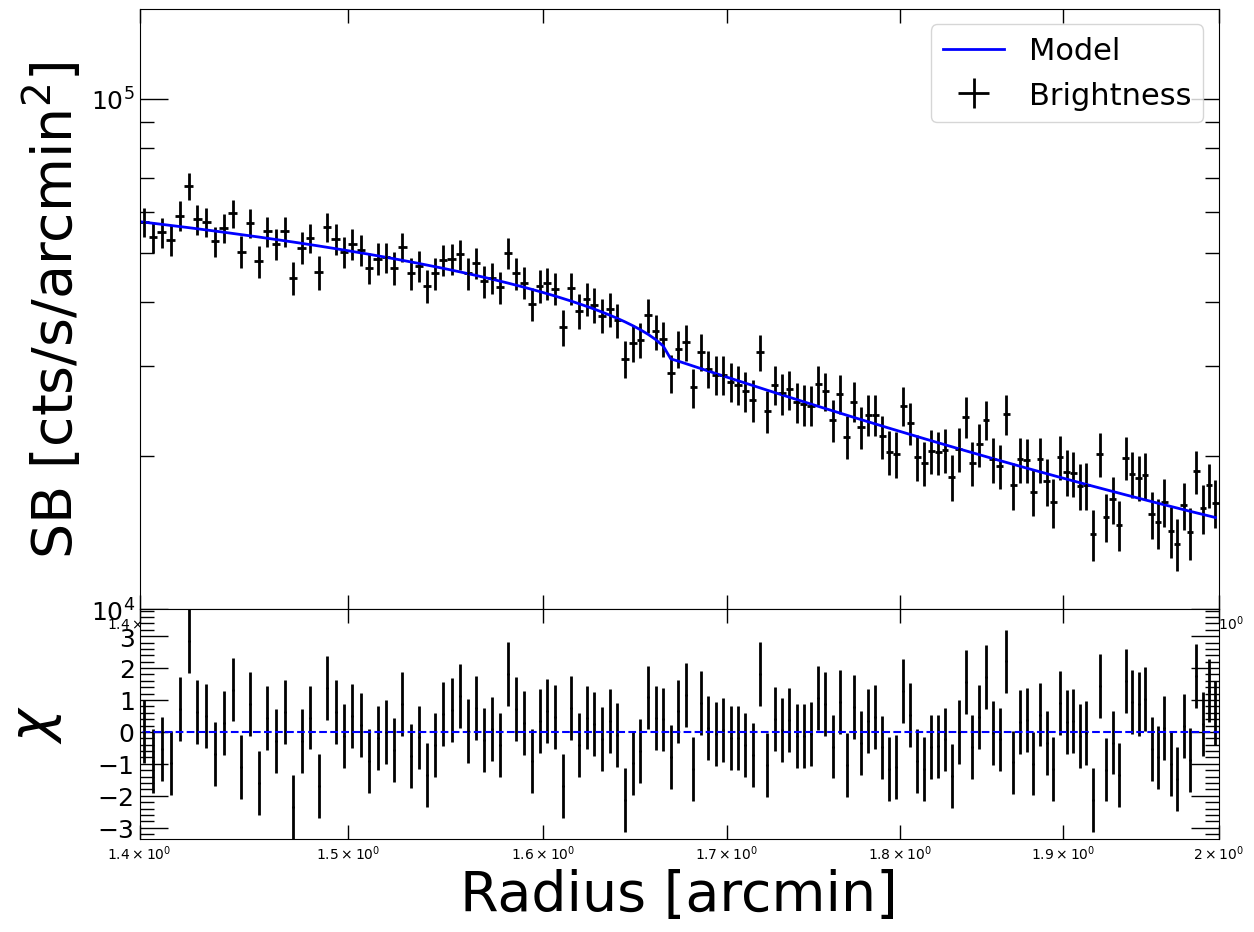

In [406]:

prof_se.Plot(model=modbkn, axes=[xmin, xmax, ymin, ymax], xscale=xscale, yscale=yscale, markersize=1)

In [343]:
save_name = 'se_wedge_edge3'

model_fit = modbkn.model(prof_se.bins, *modbkn.params)
chi = (prof_se.profile - model_fit) / prof_se.eprof

#save data, model and chi2 values
df = pd.DataFrame()
df['radius'] = prof_se.bins
df['sb'] = prof_se.profile
df['sb_err'] = prof_se.eprof
df['model'] = model_fit
df['chi'] = chi

date = '020425'

np.save(specfit_savepath + f'pyproffit_{date}_{save_name}', df.to_records())

### X-Ray Channel?

In [395]:
modbkn = pyproffit.Model(pyproffit.BknPow)

print(modbkn.parnames)

('alpha1', 'alpha2', 'rf', 'norm', 'jump', 'bkg')


<Figure size 640x480 with 0 Axes>

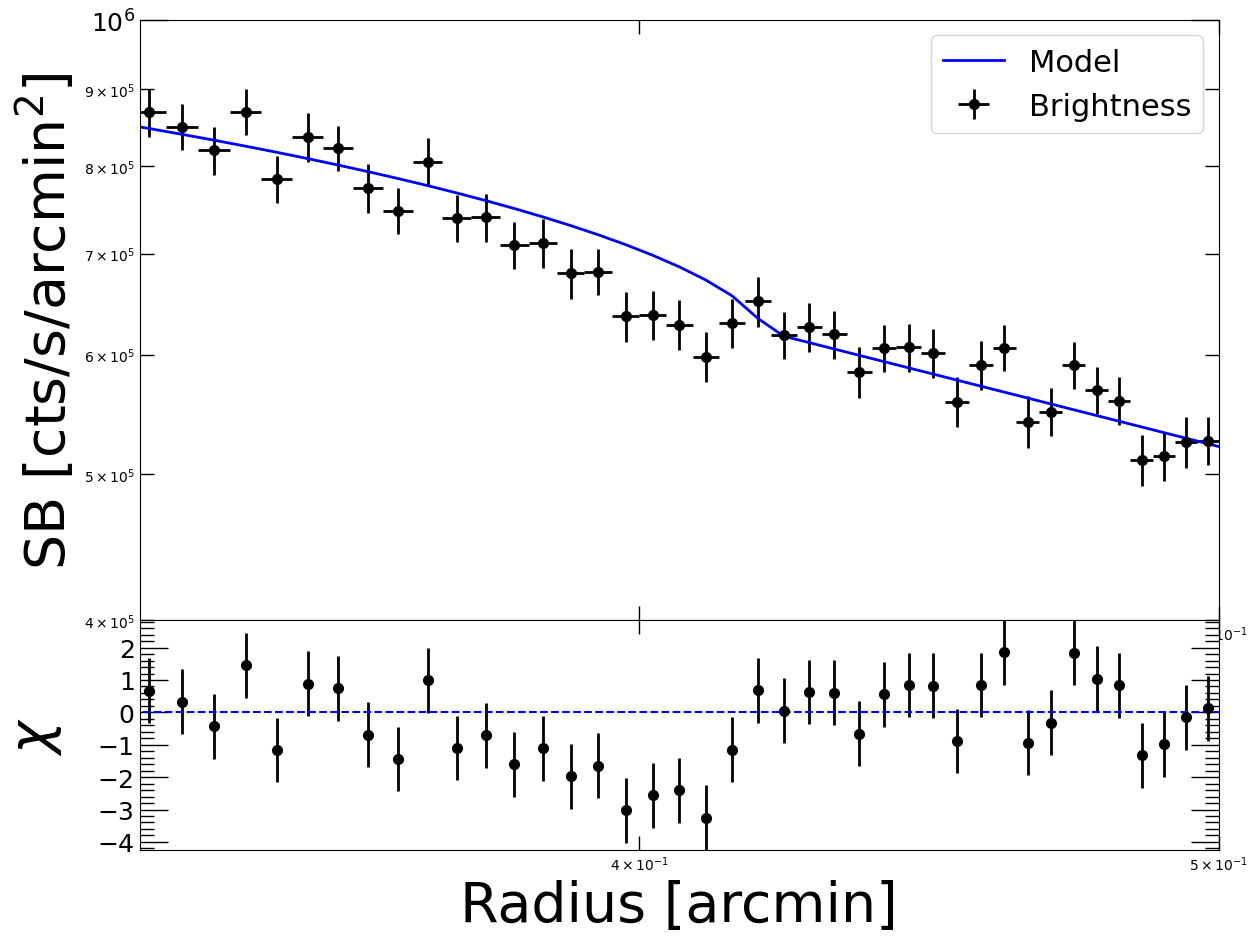

In [396]:
edge = 0.42
alpha1, alpha2, rf, norm, jump, bkg = [0.25, 1.01, edge, 6.16, 1.22, 0]
xmin, xmax = 0.33, 0.5
ymin, ymax = 0.4e6, 1e6

modbkn.SetParameters([alpha1, alpha2, rf, norm, jump, bkg])

prof_se.Plot(model=modbkn, axes=[xmin, xmax, ymin, ymax], xscale='log', yscale='log')


In [400]:
save_name = 'se_channel'

model_fit = modbkn.model(prof_se.bins, *modbkn.params)
resid = (prof_se.profile - model_fit) #/ prof_se.eprof

#save data, model and chi2 values
df = pd.DataFrame()
df['radius'] = prof_se.bins
df['sb'] = prof_se.profile
df['sb_err'] = prof_se.eprof
df['model'] = model_fit
df['resid'] = resid
df['resid_err'] = prof_se.eprof

date = '020425'

np.save(specfit_savepath + f'pyproffit_{date}_{save_name}', df.to_records())

## Hot Arc actually shock fornt?

In [40]:
annuli_width = 0.25 #arcsec
maxrad = 1.4 #arcmin
#panda(351.3228274,-12.1147346,212.68887,245.57828,1,57.828",115.656",4)

prof_ha = pyproffit.Profile(data=data, binsize=annuli_width, maxrad=maxrad,
                         center_choice='custom_fk5', center_ra=351.3427708, 
                         center_dec=-12.1220333)

#panda(351.3321221,-12.1242783,218.21695,256.09147,1,0.000",18.490",1)


Corresponding pixels coordinates:  4029.257660884446 4446.428810183314


In [41]:
prof_ha.SBprofile(angle_low=345, angle_high=350)


Showing 1 brightness profiles


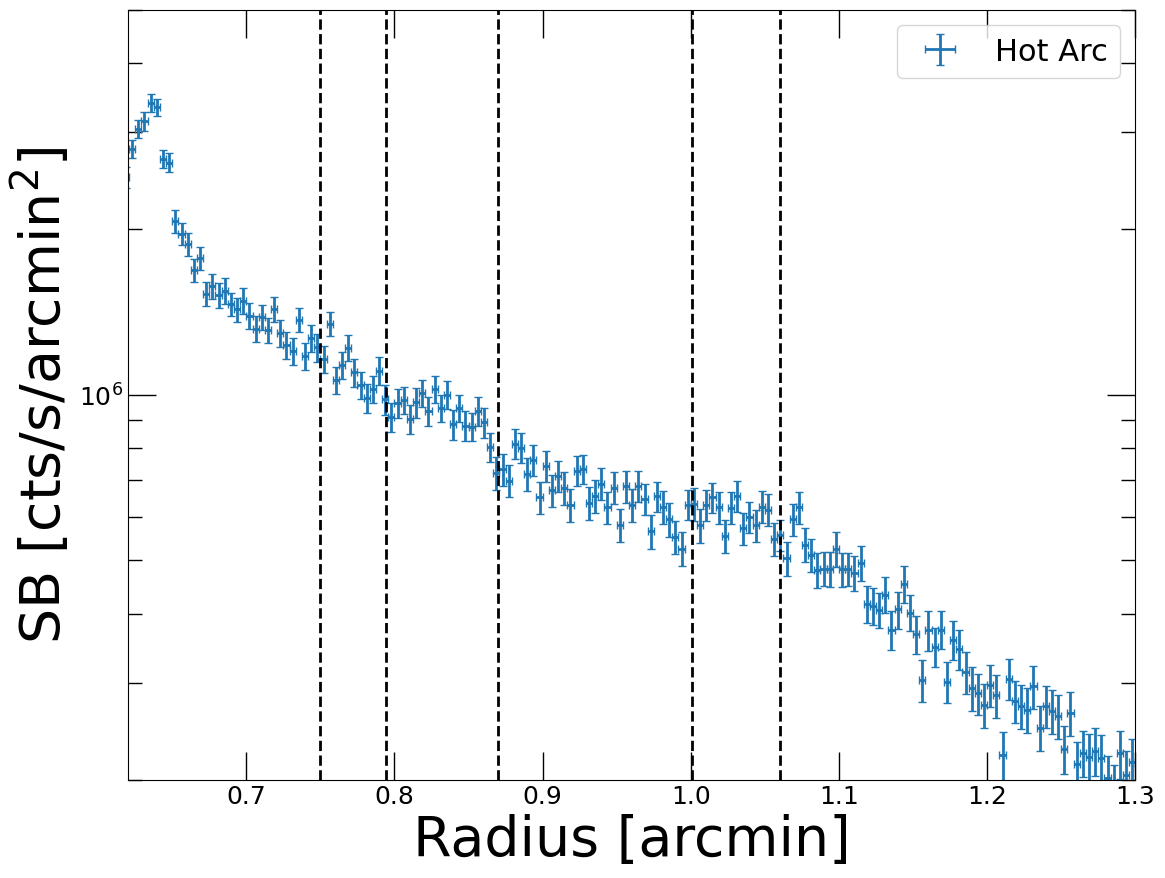

In [164]:
outfile = specfit_savepath + 'sb_ha_wedge.pdf'
pyproffit.plot_multi_profiles(profs=[prof_ha],
                             labels=['Hot Arc'], markersize=1,
                             xscale='linear', yscale='log', xlim=[0.62, 1.3],
                             ylim=[0.2e6, 5e6], plot_lines=[0.75, 0.794, 0.87,  1.001, 1.06]) #,
                             #outfile=outfile)
                             #xlim=[0.35,1.2], ylim=[0.02e6, 0.58e6])

# ie(23:25:22.2650,-12:07:19.320,0.62573',0.68830',344.99993,349.99993)
# pie(23:25:22.2650,-12:07:19.320,0.68830',0.75088',344.99993,349.99993)
# pie(23:25:22.2650,-12:07:19.320,0.75088',0.81345',344.99993,349.99993)
# pie(23:25:22.2650,-12:07:19.320,0.81345',0.87603',344.99993,349.99993)
# pie(23:25:22.2650,-12:07:19.320,0.87603',0.93860',344.99993,349.99993)
# pie(23:25:22.2650,-12:07:19.320,0.93860',1.00117',344.99993,349.99993)
# pie(23:25:22.2650,-12:07:19.320,1.00117',1.06375',344.99993,349.99993)
# pie(23:25:22.2650,-12:07:19.320,1.06375',1.12632',344.99993,349.99993)
# pie(23:25:22.2650,-12:07:19.320,1.12632',1.18890',344.99993,349.99993)
# pie(23:25:22.2650,-12:07:19.320,1.18890',1.25147',344.99993,349.99993)



#### Fit Hot Arc

In [153]:
modbkn = pyproffit.Model(pyproffit.BknPow)

print(modbkn.parnames)

('alpha1', 'alpha2', 'rf', 'norm', 'jump', 'bkg')


<Figure size 640x480 with 0 Axes>

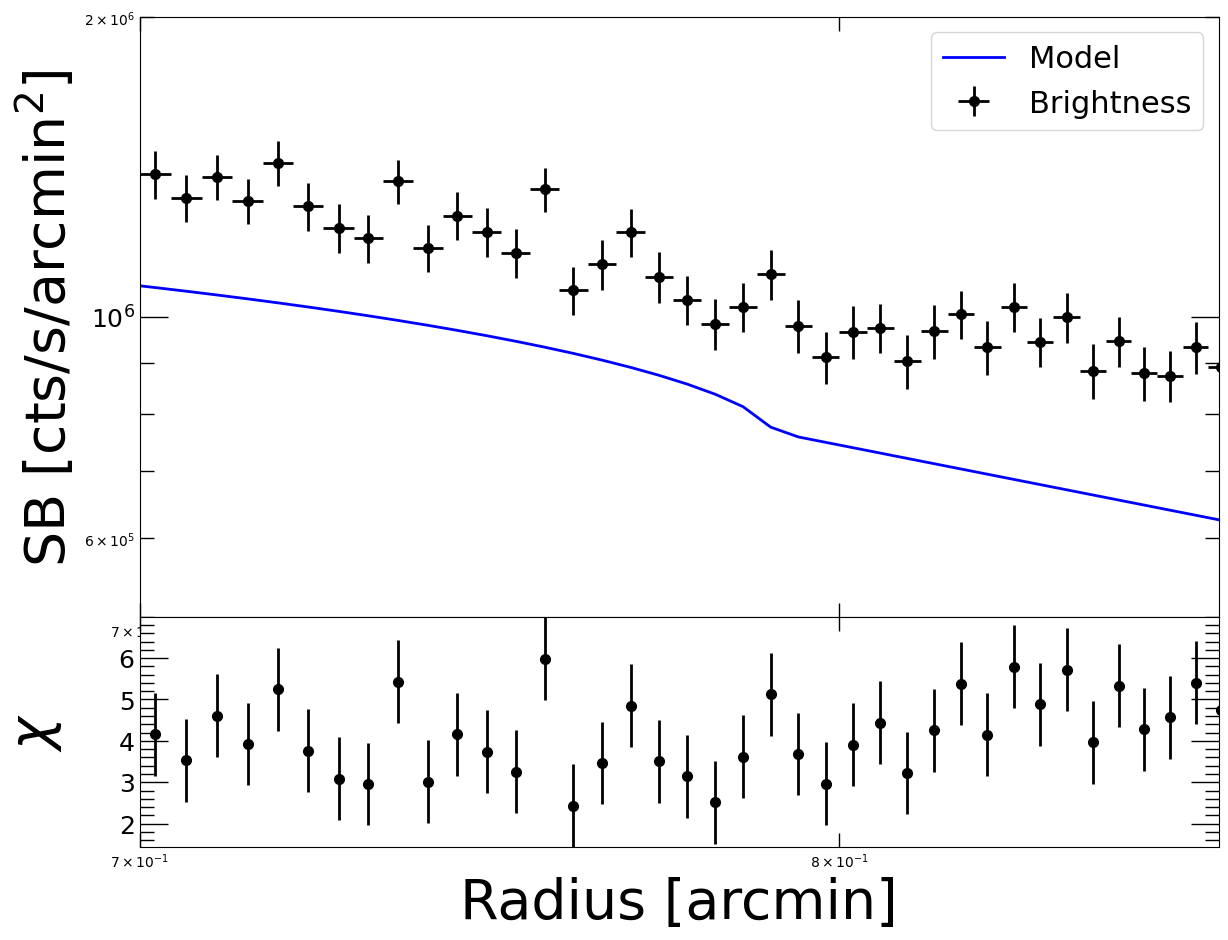

In [160]:
alpha1, alpha2, rf, norm, jump, bkg = [0.01, 1.7, 0.79, 6.2, 1.2, 0]
xmin, xmax = 0.7, 0.86
ymin, ymax = 0.5e6, 2e6

modbkn.SetParameters([alpha1, alpha2, rf, norm, jump, bkg])

prof_ha.Plot(model=modbkn, axes=[xmin, xmax, ymin, ymax], xscale='log', yscale='log')


In [161]:
# fitobj = pyproffit.Fitter(model=modbkn, profile=prof, alpha1=0.8, alpha2=2.0, rf=3.5, jump=1.8, norm=-1.8, bkg=-4.0,
#               fitlow=1.0, fithigh=7.0)
fitobj = pyproffit.Fitter(model=modbkn, profile=prof_ha, alpha1=alpha1, alpha2=alpha2, rf=rf, jump=jump, norm=norm, bkg=bkg,
                fitlow=xmin, fithigh=xmax)

fitobj.Migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 33.15                      │              Nfcn = 849              │
│ EDM = 1.33e-05 (Goal: 0.0002)    │            time = 1.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

<Figure size 640x480 with 0 Axes>

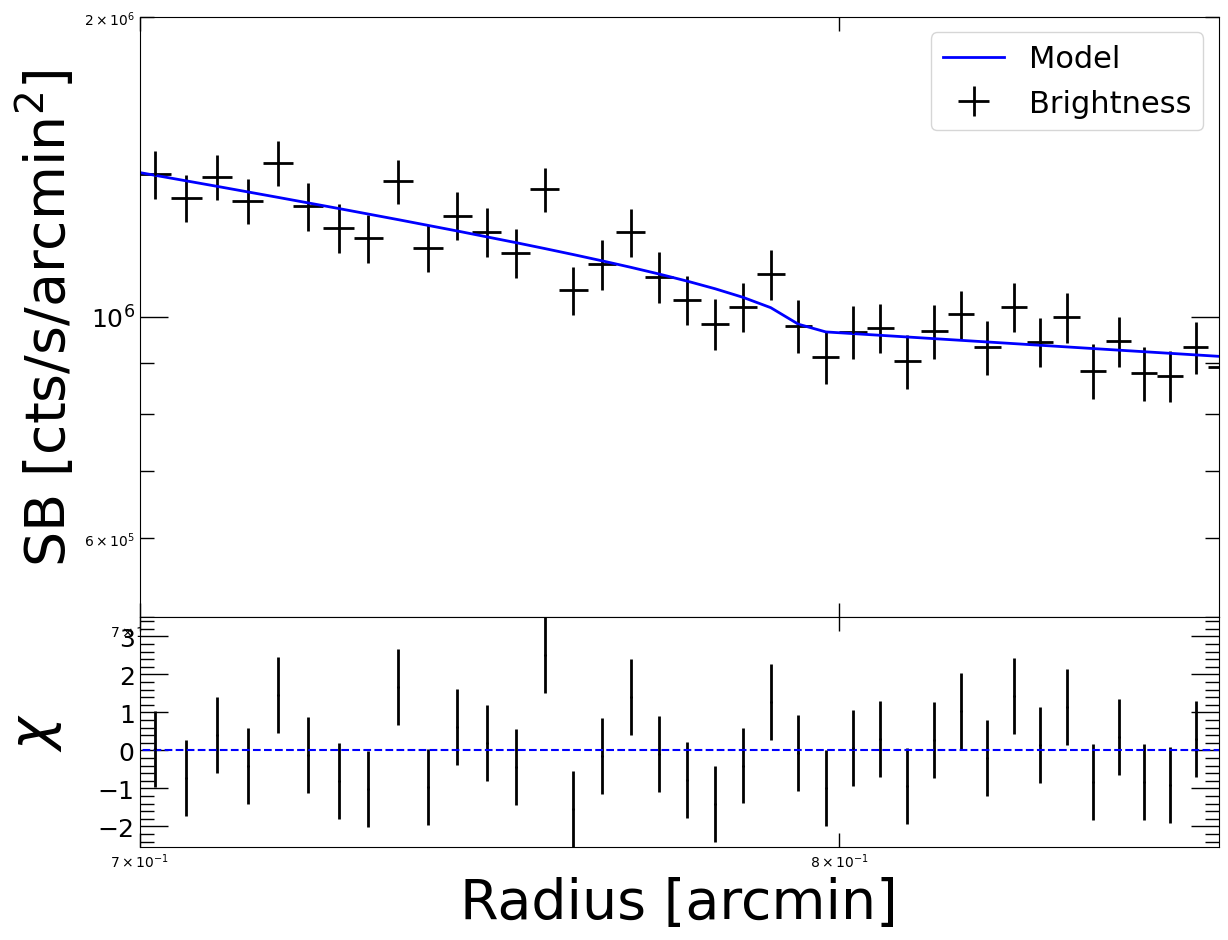

In [162]:
prof_ha.Plot(model=modbkn, axes=[xmin, xmax, ymin, ymax], xscale='log', yscale='log', markersize=1)

In [165]:
specfit_savepath = path_to_ca2597 + 'analysis/data/spectral_fitting_results/'
save_name = 'hotarc_wedge_edge0'

model_fit = modbkn.model(prof_ha.bins, *modbkn.params)
chi = (prof_ha.profile - model_fit) / prof_ha.eprof

#save data, model and chi2 values
df = pd.DataFrame()
df['radius'] = prof_ha.bins
df['sb'] = prof_ha.profile
df['sb_err'] = prof_ha.eprof
df['model'] = model_fit
df['chi'] = chi

date = '022525'

np.save(specfit_savepath + f'pyproffit_{date}_{save_name}', df.to_records())

/var/folders/q9/nqsw_gnn1kq4pydg796lnc880000gn/T/ipykernel_19231/1098174653.py:5: RuntimeWarning: divide by zero encountered in divide
  chi = (prof_ha.profile - model_fit) / prof_ha.eprof


#### Fit Edge #1

In [50]:
modbkn = pyproffit.Model(pyproffit.BknPow)

print(modbkn.parnames)

('alpha1', 'alpha2', 'rf', 'norm', 'jump', 'bkg')


<Figure size 640x480 with 0 Axes>

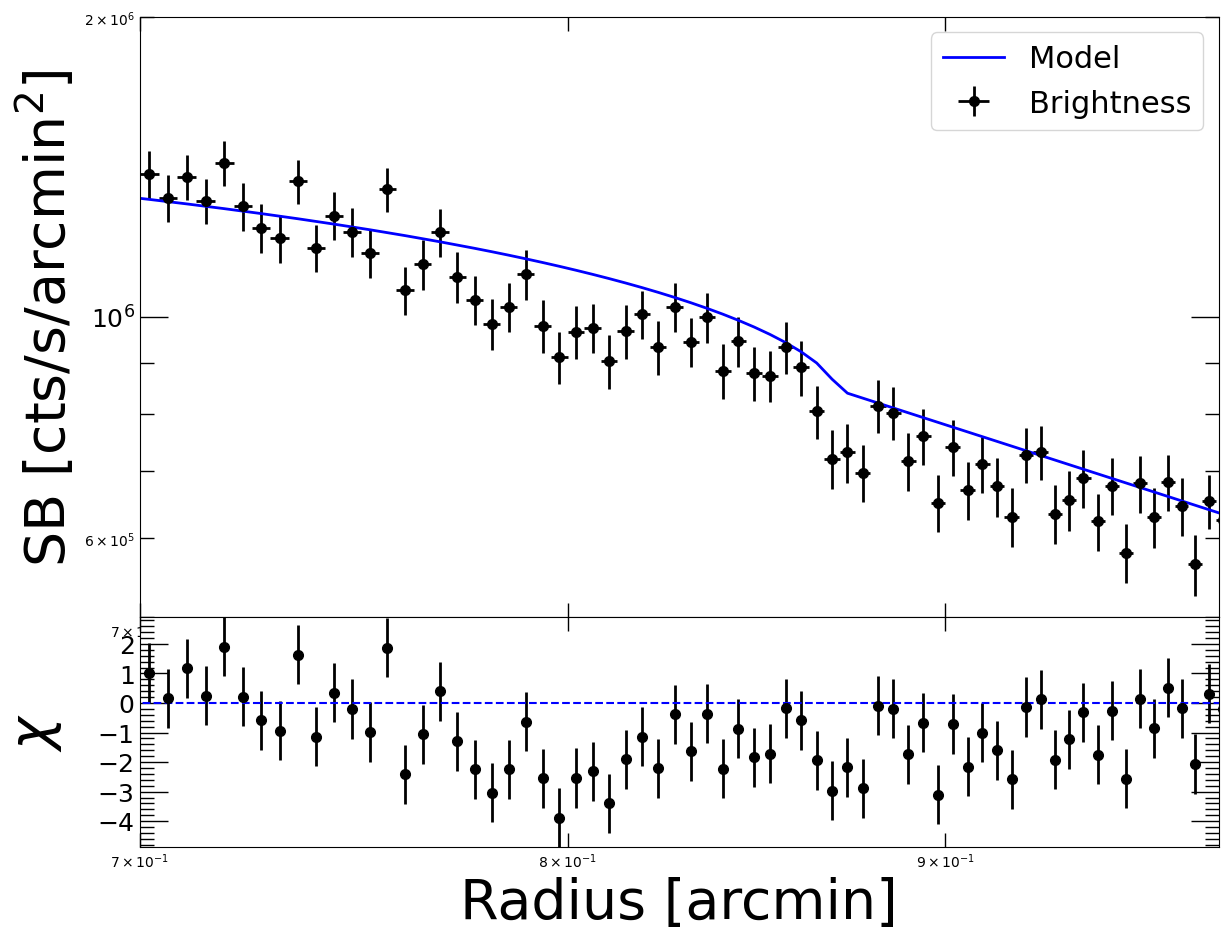

In [67]:
alpha1, alpha2, rf, norm, jump, bkg = [0.01, 1.7, 0.87, 6.2, 1.2, 0]
xmin, xmax = 0.7, 0.98
ymin, ymax = 0.5e6, 2e6

modbkn.SetParameters([alpha1, alpha2, rf, norm, jump, bkg])

prof_ha.Plot(model=modbkn, axes=[xmin, xmax, ymin, ymax], xscale='log', yscale='log')


In [68]:
# fitobj = pyproffit.Fitter(model=modbkn, profile=prof, alpha1=0.8, alpha2=2.0, rf=3.5, jump=1.8, norm=-1.8, bkg=-4.0,
#               fitlow=1.0, fithigh=7.0)
fitobj = pyproffit.Fitter(model=modbkn, profile=prof_ha, alpha1=alpha1, alpha2=alpha2, rf=rf, jump=jump, norm=norm, bkg=bkg,
                fitlow=xmin, fithigh=xmax)

fitobj.Migrad()

/Users/osaseomoruyi/opt/anaconda3/envs/pyprof_env/lib/python3.9/site-packages/pyproffit/fitting.py:58: FutureWarning: make_func_code is deprecated: Use of ``func_code`` attribute to declare parameters is deprecated. Use ``_parameters`` instead, which is a dict of parameter names to limits.
  self.func_code = iminuit.util.make_func_code(iminuit.util.describe(self.model)[1:])
/Users/osaseomoruyi/opt/anaconda3/envs/pyprof_env/lib/python3.9/site-packages/pyproffit/models.py:214: RuntimeWarning: overflow encountered in power
  c2 = np.power(10., bkg)
/Users/osaseomoruyi/opt/anaconda3/envs/pyprof_env/lib/python3.9/site-packages/pyproffit/fitting.py:74: RuntimeWarning: overflow encountered in square
  chi2 = np.sum((self.y[reg][nonz] - ym[reg][nonz])**2/self.dy[reg][nonz]**2)


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 70.66                      │             Nfcn = 1072              │
│ EDM = 0.79 (Goal: 0.0002)        │            time = 2.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

<Figure size 640x480 with 0 Axes>

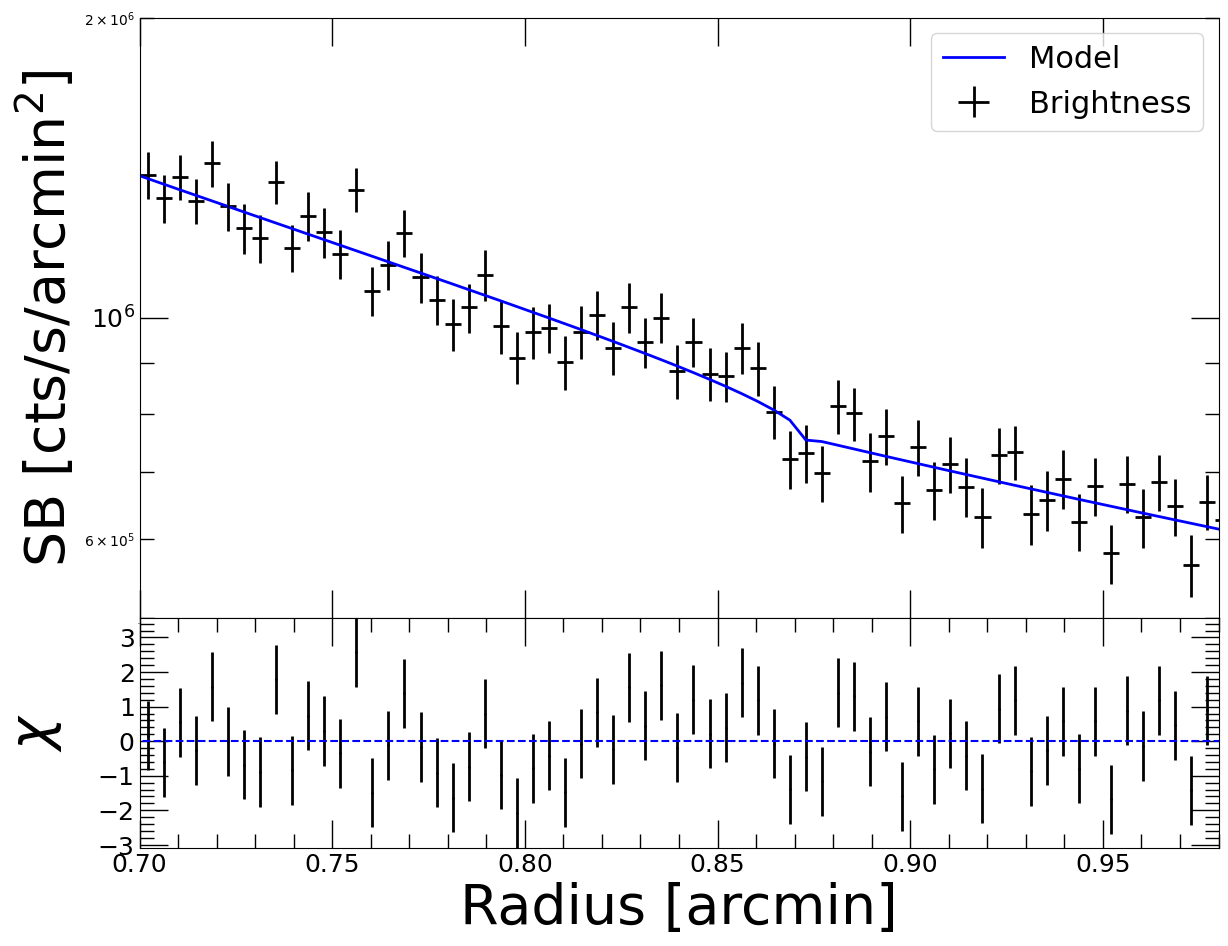

In [69]:
prof_ha.Plot(model=modbkn, axes=[xmin, xmax, ymin, ymax], xscale='linear', yscale='log', markersize=1)

In [70]:
save_name = 'hotarc_wedge_edge1'

model_fit = modbkn.model(prof_ha.bins, *modbkn.params)
chi = (prof_ha.profile - model_fit) / prof_ha.eprof

#save data, model and chi2 values
df = pd.DataFrame()
df['radius'] = prof_ha.bins
df['sb'] = prof_ha.profile
df['sb_err'] = prof_ha.eprof
df['model'] = model_fit
df['chi'] = chi

date = '022525'

np.save(specfit_savepath + f'pyproffit_{date}_{save_name}', df.to_records())

/var/folders/q9/nqsw_gnn1kq4pydg796lnc880000gn/T/ipykernel_19231/2290081175.py:5: RuntimeWarning: divide by zero encountered in divide
  chi = (prof_ha.profile - model_fit) / prof_ha.eprof


In [71]:
fitobj.out

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 70.66                      │             Nfcn = 1072              │
│ EDM = 0.79 (Goal: 0.0002)        │            time = 2.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ alpha1 │   1.43    │   0.27    │            │            │         │         │       │
│ 1 │ alpha2 │   1.42    │   0.18    │            │            │         │         │       │
│ 2 │ rf     │872.9167e-3│ 0.0020e-3 │            │            │         │         │       │
│ 3 │ norm   │   6.064   │   0.027   │            │            │         │         │       │
│ 4 │ jump   │   1.18    │   0.08    │            │            │         │         │       │
│ 5 │ bkg    │    -0     │   3.3e3   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────────────────┐
│        │    alpha1    alpha2        rf      norm      jump       bkg │
├────────┼─────────────────────────────────────────────────────────────┤
│ alpha1 │    0.0705     0.001 -1.096e-9   -6.3e-3    -0.010      0.08 │
│ alpha2 │     0.001    0.0314 -4.947e-9    1.3e-3    -0.013     0.277 │
│     rf │ -1.096e-9 -4.947e-9  3.92e-12   -42e-12  2.409e-9  9.754e-9 │
│   norm │   -6.3e-3    1.3e-3   -42e-12  0.000708    0.5e-3  -29.8e-3 │
│   jump │    -0.010    -0.013  2.409e-9    0.5e-3   0.00687     0.021 │
│    bkg │      0.08     0.277  9.754e-9  -29.8e-3     0.021  1.07e+07 │
└────────┴─────────────────────────────────────────────────────────────┘

#### Fit Edge #2

In [72]:
modbkn = pyproffit.Model(pyproffit.BknPow)

print(modbkn.parnames)

('alpha1', 'alpha2', 'rf', 'norm', 'jump', 'bkg')


<Figure size 640x480 with 0 Axes>

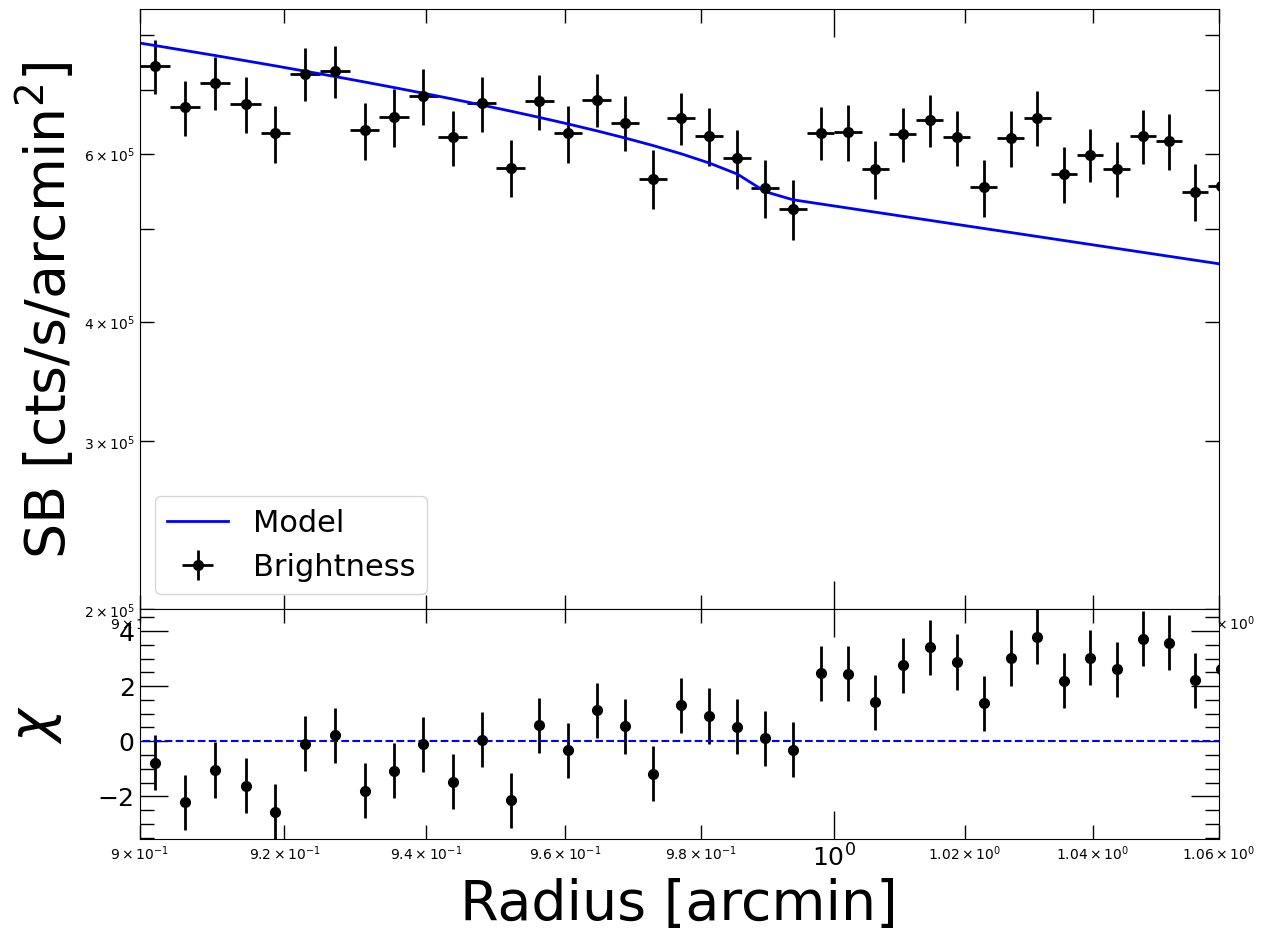

In [145]:
alpha1, alpha2, rf, norm, jump, bkg = [1.1, 1.7, 0.99, 5.95, 1.2, 0]
xmin, xmax = 0.9, 1.06
ymin, ymax = 0.2e6, 0.85e6

modbkn.SetParameters([alpha1, alpha2, rf, norm, jump, bkg])

prof_ha.Plot(model=modbkn, axes=[xmin, xmax, ymin, ymax], xscale='log', yscale='log')


In [142]:
# fitobj = pyproffit.Fitter(model=modbkn, profile=prof, alpha1=0.8, alpha2=2.0, rf=3.5, jump=1.8, norm=-1.8, bkg=-4.0,
#               fitlow=1.0, fithigh=7.0)
fitobj = pyproffit.Fitter(model=modbkn, profile=prof_ha, alpha1=alpha1, alpha2=alpha2, rf=rf, jump=jump, norm=norm, bkg=bkg,
                fitlow=xmin, fithigh=xmax)

fitobj.Migrad()

/Users/osaseomoruyi/opt/anaconda3/envs/pyprof_env/lib/python3.9/site-packages/pyproffit/fitting.py:58: FutureWarning: make_func_code is deprecated: Use of ``func_code`` attribute to declare parameters is deprecated. Use ``_parameters`` instead, which is a dict of parameter names to limits.
  self.func_code = iminuit.util.make_func_code(iminuit.util.describe(self.model)[1:])


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 33.25                      │             Nfcn = 1388              │
│ EDM = 0.301 (Goal: 0.0002)       │            time = 2.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

<Figure size 640x480 with 0 Axes>

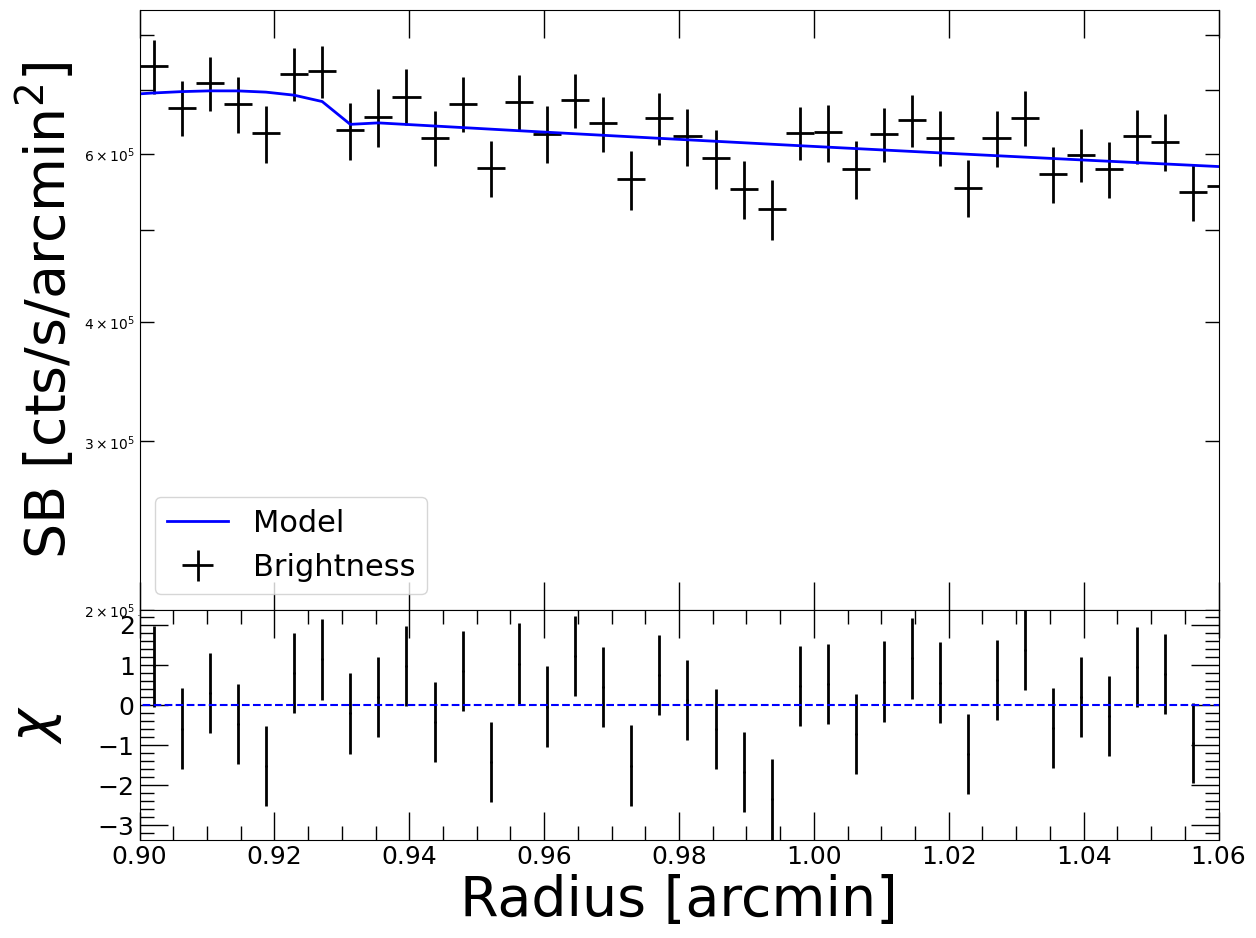

In [132]:
prof_ha.Plot(model=modbkn, axes=[xmin, xmax, ymin, ymax], xscale='linear', yscale='log', markersize=1)

In [ ]:
specfit_savepath = path_to_ca2597 + 'analysis/data/spectral_fitting_results/'
save_name = 'hotarc_wedge_edge1'

model_fit = modbkn.model(prof_ha.bins, *modbkn.params)
chi = (prof_ha.profile - model_fit) / prof_ha.eprof

#save data, model and chi2 values
df = pd.DataFrame()
df['radius'] = prof_ha.bins
df['sb'] = prof_ha.profile
df['sb_err'] = prof_ha.eprof
df['model'] = model_fit
df['chi'] = chi

date = '022525'

np.save(specfit_savepath + f'pyproffit_{date}_{save_name}', df.to_records())

/var/folders/q9/nqsw_gnn1kq4pydg796lnc880000gn/T/ipykernel_19231/2290081175.py:5: RuntimeWarning: divide by zero encountered in divide
  chi = (prof_ha.profile - model_fit) / prof_ha.eprof


In [ ]:
fitobj.out

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 70.66                      │             Nfcn = 1072              │
│ EDM = 0.79 (Goal: 0.0002)        │            time = 2.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ alpha1 │   1.43    │   0.27    │            │            │         │         │       │
│ 1 │ alpha2 │   1.42    │   0.18    │            │            │         │         │       │
│ 2 │ rf     │872.9167e-3│ 0.0020e-3 │            │            │         │         │       │
│ 3 │ norm   │   6.064   │   0.027   │            │            │         │         │       │
│ 4 │ jump   │   1.18    │   0.08    │            │            │         │         │       │
│ 5 │ bkg    │    -0     │   3.3e3   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────────────────┐
│        │    alpha1    alpha2        rf      norm      jump       bkg │
├────────┼─────────────────────────────────────────────────────────────┤
│ alpha1 │    0.0705     0.001 -1.096e-9   -6.3e-3    -0.010      0.08 │
│ alpha2 │     0.001    0.0314 -4.947e-9    1.3e-3    -0.013     0.277 │
│     rf │ -1.096e-9 -4.947e-9  3.92e-12   -42e-12  2.409e-9  9.754e-9 │
│   norm │   -6.3e-3    1.3e-3   -42e-12  0.000708    0.5e-3  -29.8e-3 │
│   jump │    -0.010    -0.013  2.409e-9    0.5e-3   0.00687     0.021 │
│    bkg │      0.08     0.277  9.754e-9  -29.8e-3     0.021  1.07e+07 │
└────────┴─────────────────────────────────────────────────────────────┘